### ETS forecasting on 2017

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import AutoETS
from darts.metrics import mape, mae, rmse

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2012-2016) and test (2017)
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))

c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
C:\Users\USER\AppData\Local\Temp\ipykernel_70936\2842710166.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffil

### Let ETS find best parameter

In [5]:
# train an ETS model (Error, Trend, Seasonality)
auto_ets = AutoETS(season_length=52, model="ZZZ") # ZZZ is auto everything (will choose ZAN), ZAA = Holt Winters, ZAN = Holt method, ZNN = SES

auto_ets.fit(train_ts)

AutoETS(add_encoders=None, quantiles=None, random_state=None, season_length=52, model=ZZZ)

In [6]:
# forecast the same number of steps as in the test set
h = len(test_ts)
ETS_forecast = auto_ets.predict(n=h)

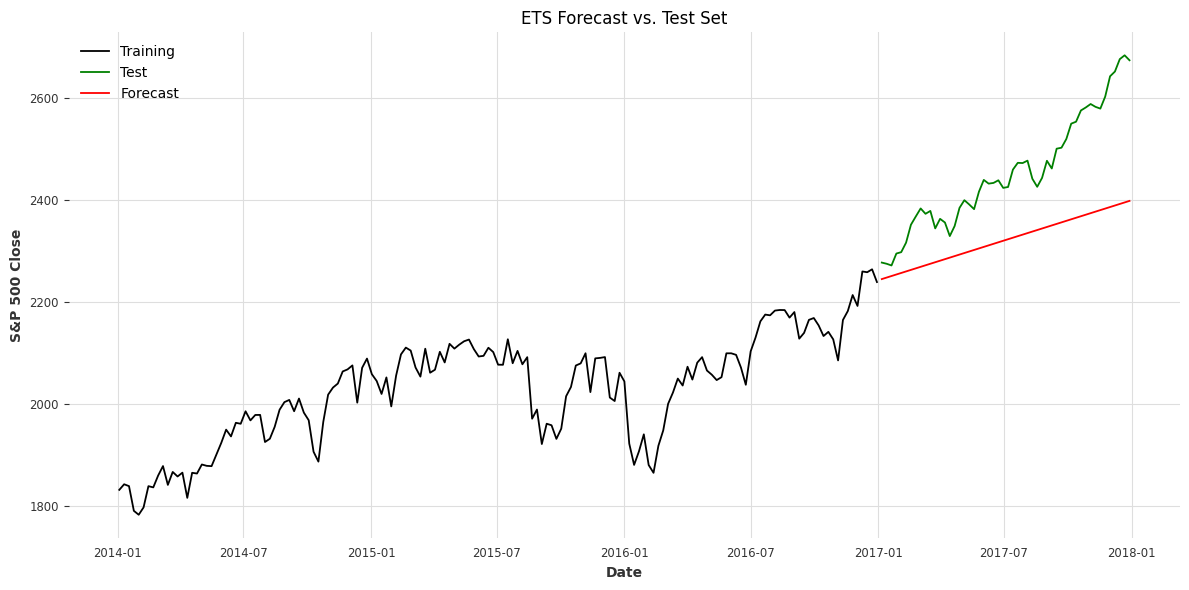

MAPE: 5.20%
MAE:  130.16
RMSE: 146.99



In [7]:
# get only the part of train_ts from 2014-01-01 onward
train_slice = train_ts.slice(pd.Timestamp("2014-01-01"), train_ts.end_time())

# plot train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts.time_index, test_ts.values(), label="Test", color="green")
plt.plot(ETS_forecast.time_index, ETS_forecast.values(), label="Forecast", color="red")

plt.title("ETS Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

print(f"MAPE: {mape(test_ts, ETS_forecast):.2f}%")
print(f"MAE:  {mae(test_ts, ETS_forecast):.2f}")
print(f"RMSE: {rmse(test_ts, ETS_forecast):.2f}\n")

In [8]:
import os
import pandas as pd

def save_preds(ts_actual, ts_pred, model_name, type, path="results"):
    # turn into pandas.Series and pick only the timestamps present in both
    actual = ts_actual.to_series()
    pred   = ts_pred.to_series()
    common = actual.index.intersection(pred.index)

    # build a simple DataFrame
    df = pd.DataFrame({
        "actual":     actual.loc[common],
        "prediction": pred.loc[common],
        "model":      model_name
    })
    df.index.name = "timestamp"

    # ensure the output folder exists and save
    os.makedirs(path, exist_ok=True)
    out_fn = os.path.join(path, f"{model_name}_{type}.csv")
    df.to_csv(out_fn, index=True)

    return df

In [9]:
df_2017 = save_preds(test_ts, ETS_forecast, model_name="ETS", type="test_2017", path="results")

### Forecast on 2023

In [11]:
# load data
df = sp500.history(start="2014-01-01", end="2024-01-01")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

# Fix missing data
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2012-2022) and test (2023-2024)
train_ts_2, test_ts_2 = series.split_before(pd.Timestamp("2023-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_70936\4001692405.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [12]:
auto_ets_2 = AutoETS(season_length=52, model="ZZZ") # zzz is auto everything

auto_ets_2.fit(train_ts_2)

AutoETS(add_encoders=None, quantiles=None, random_state=None, season_length=52, model=ZZZ)

In [13]:
# forecast the same number of steps as in the test set
h = len(test_ts_2)
ETS_forecast_2 = auto_ets_2.predict(n=h)

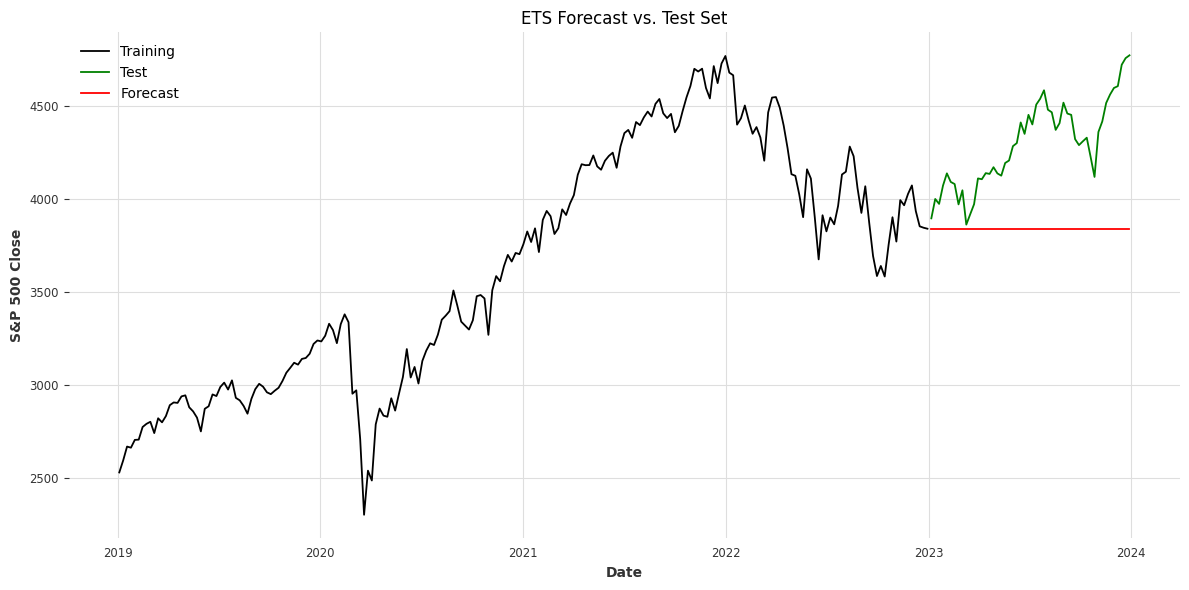

MAPE: 10.26%
MAE:  451.07
RMSE: 505.75



In [14]:
# get only the part of train_ts from 2016-01-01 onward
train_slice_2 = train_ts_2.slice(pd.Timestamp("2019-01-01"), train_ts_2.end_time())

# plot train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_slice_2.time_index, train_slice_2.values(), label="Training")
plt.plot(test_ts_2.time_index, test_ts_2.values(), label="Test", color="green")
plt.plot(ETS_forecast_2.time_index, ETS_forecast_2.values(), label="Forecast", color="red")

plt.title("ETS Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

print(f"MAPE: {mape(test_ts_2, ETS_forecast_2):.2f}%")
print(f"MAE:  {mae(test_ts_2, ETS_forecast_2):.2f}")
print(f"RMSE: {rmse(test_ts_2, ETS_forecast_2):.2f}\n")

In [15]:
df_2023 = save_preds(test_ts_2, ETS_forecast_2, model_name="ETS", type="test_2023", path="results")

### Backtesting

In [16]:
df = sp500.history(start="2012-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

# resample to weekly
weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

C:\Users\USER\AppData\Local\Temp\ipykernel_70936\3861653806.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [17]:
# back test period
backtest_start = pd.Timestamp("2023-01-01")
backtest_end   = pd.Timestamp("2024-12-31")

auto_ets_2 = AutoETS(season_length=52, model="ZZZ")
auto_ets_2.fit(series[:backtest_start])

AutoETS(add_encoders=None, quantiles=None, random_state=None, season_length=52, model=ZZZ)

In [18]:
# perform the historical (rolling) forecasts
backtest_forecast = auto_ets_2.historical_forecasts(
    series=series,
    start=backtest_start,
    forecast_horizon=1,    # 1 week ahead
    stride=1,              # roll forward 1 week each time
    retrain=False,         # No re-fit on all data up to each forecast point
    last_points_only=True  # keep only the 1-step-ahead point per window
)

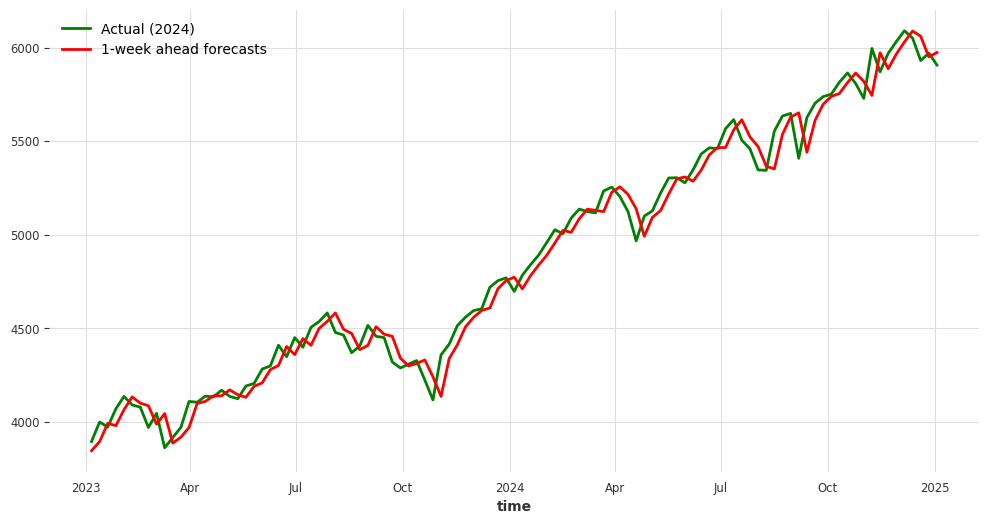

MAPE: 1.44%
MAE:  69.66
RMSE: 86.45


In [19]:
# slice actuals to the same indices
actuals_bt = series[backtest_start:backtest_end]

# plot
plt.figure(figsize=(12,6))
actuals_bt.plot(label="Actual (2024)", color="green")
backtest_forecast.plot(label="1-week ahead forecasts", color="red")
plt.legend()
plt.show()

# evaluate
print(f"MAPE: {mape(actuals_bt, backtest_forecast):.2f}%")
print(f"MAE:  {mae(actuals_bt, backtest_forecast):.2f}")
print(f"RMSE: {rmse(actuals_bt, backtest_forecast):.2f}")

In [20]:
from sklearn.metrics import precision_score

# convert both to pandas Series for easy shifting/alignment
pred = backtest_forecast.to_series() # one-week-ahead forecasts
actual = actuals_bt.to_series() # the real weekly closes

# get last week’s actual price at each forecast date
prev_price = actual.shift(1)

# drop the very first point where prev_price is NaN
mask = prev_price.notna()
pred = pred[mask]
actual = actual[mask]
prev_price = prev_price[mask]

# compute predicted & actual directions: +1 for up, -1 for down
pred_dir   = np.where(pred   > prev_price,  1, -1)
actual_dir = np.where(actual > prev_price,  1, -1)

# compute directional accuracy
dir_acc = (pred_dir == actual_dir).mean() * 100
print(f"Directional accuracy: {dir_acc:.2f}%")

# compute precision for the "up" class
y_pred = (pred_dir == 1)
y_true = (actual_dir == 1)
precision = precision_score(y_true, y_pred) * 100
print(f"Precision (stock actually increase): {precision:.2f}%")

Directional accuracy: 45.19%
Precision (stock actually increase): 55.74%


In [21]:
df_2023 = save_preds(actuals_bt, backtest_forecast, model_name="ETS", type="backtest", path="results")